[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Потоковая передача (Streaming)

## Итоги предыдущего модуля

В модуле 2 мы рассмотрели несколько способов настройки состояния графа и памяти.

Мы создали чат-бота с внешней памятью, способного поддерживать длительные диалоги.

## Цели текущего модуля

Этот модуль посвящен концепции `human-in-the-loop` (человек в цикле), которая строится на памяти и позволяет пользователям напрямую взаимодействовать с графами различными способами.

Чтобы подготовить почву для `human-in-the-loop`, мы сначала углубимся в потоковую передачу, которая предоставляет несколько способов визуализации вывода графа (например, состояние узлов или токены чат-модели) в процессе выполнения.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_mistralai langgraph_sdk

## Потоковая передача (Streaming)

LangGraph разработан с [поддержкой потоковой передачи как функции первого класса](https://docs.langchain.com/oss/python/langgraph/streaming).

Давайте настроим нашего Чат-бота из Модуля 2 и покажем различные способы потоковой передачи вывода из графа во время выполнения.

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


Обратите внимание, что мы используем `RunnableConfig` с `call_model` для включения потоковой передачи на уровне токенов. Это [требуется только для Python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). Мы включаем это на случай, если вы запускаете этот блокнот в CoLab, который использует Python 3.x.

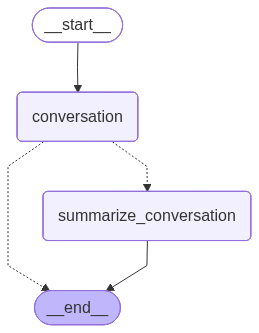

In [3]:
from IPython.display import Image, display
from typing import Literal

from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatMistralAI(model="mistral-small-latest", temperature=0) 

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Потоковая передача полного состояния

Теперь давайте рассмотрим способы [потоковой передачи состояния нашего графа](https://docs.langchain.com/oss/python/langgraph/streaming#supported-stream-modes).

`.stream` и `.astream` — это синхронные и асинхронные методы для потоковой передачи результатов.

LangGraph поддерживает несколько [режимов потоковой передачи](https://docs.langchain.com/oss/python/langgraph/streaming#stream-graph-state) для состояния графа.

* `values`: Передает полное состояние графа после вызова каждого узла.
* `updates`: Передает обновления состояния графа после вызова каждого узла.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Давайте рассмотрим `stream_mode="updates"`.

Поскольку мы используем потоковую передачу с `updates`, мы видим только обновления состояния после выполнения каждого узла в графе.

Каждый `chunk` представляет собой словарь, где ключом является `node_name`, а значением — обновленное состояние.

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hey Lance! Nice to meet you. 😊 What's up? How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 8, 'total_tokens': 31, 'completion_tokens': 23}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop', 'model_provider': 'mistralai'}, id='lc_run--3b21ca62-9c82-4b92-8295-d503d60add27-0', usage_metadata={'input_tokens': 8, 'output_tokens': 23, 'total_tokens': 31})}}


Теперь давайте просто выведем обновление состояния для сообщений. И мы увидим только обновление сообщений.

In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hey Lance! Nice to meet you—what’s on your mind today? 😊 Whether you’ve got questions, need advice, or just want to chat, I’m here for it. What’s up?


Теперь посмотрим на `stream_mode="values"`.

Это `полное состояние` графа после вызова узла `conversation`.

In [9]:
# Start conversation, again
config = {"configurable": {"thread_id": "21"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hey Lance! Nice to meet you. 😊 What's up? How can I help you today?
---------------------------------------------------------------------------


### Потоковая передача токенов

Часто нам нужно передавать в потоке не только состояние графа.

В частности, для вызовов чат-моделей обычно stream-ятся токены по мере их генерации.

Мы можем сделать это [с помощью метода `.astream_events`](https://docs.langchain.com/oss/python/langchain/models#advanced-streaming-topics:streaming-events), который передает события по мере их возникновения внутри узлов!

Каждое событие представляет собой словарь с несколькими ключами:

* `event`: Тип генерируемого события.
* `name`: Название события.
* `data`: Данные, связанные с событием.
* `metadata`: Содержит `langgraph_node`, узел, генерирующий событие.

Давайте посмотрим.

In [7]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

Ключевой момент заключается в том, что токены от чат-моделей внутри вашего графа имеют тип `on_chat_model_stream`.

Мы можем использовать `event['metadata']['langgraph_node']` для выбора узла, из которого нужно stream-ить данные.

И мы можем использовать `event['data']` для получения фактических данных для каждого события, которые в данном случае представляют собой `AIMessageChunk`.

In [10]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk': AIMessageChunk(content=' **', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk': AIMessageChunk(content='San', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--a5ca1797-408e-41cd-9976-7912a6e70595')}
{'chunk'

Как видно выше, просто используйте ключ `chunk` для получения `AIMessageChunk`.

In [11]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| **|San| Francisco| |4|9|ers|**| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| **|National| Football| League| (|N|FL|)**| as| a| member| of| the| **|National| Football| Conference| (|N|FC|)| West|**| division|.| Here|’s| an| overview| of| the| team|:

|###| **|Team| History| &| Key| F|acts|**
|-| **|Found|ed|:**| |1|9|4|6| (|as| a| charter| member| of| the| All|-Amer|ica| Football| Conference|,| later| joining| the| NFL| in| |1|9|5|0|).
|-| **|Home| Stadium|:**| **|Le|vi|’s| Stadium|**| (|Santa| Clara|,| California|)| since| |2|0|1|4|.
|-| **|Previous| Stadium|s|:**| Cand|l|est|ick| Park| (|1|9|7|1|–|2|0|1|3|),| Ke|zar| Stadium| (|1|9|4|6|–|1|9|7|0|).
|-| **|Team| Colors|:**| Red|,| gold|,| and| white|.
|-| **|M|asc|ot|:**| **|S|ourd|ough| Sam|**| (|a| gold| miner|).

|###| **|Not|able| Ach|ie|vements|**
|-| **|5| Super| Bowl| Championships|**| (|t|ied| for| |3|rd| most| in| NFL| history|):
| | -| **|Super| Bow

### Потоковая передача с LangGraph API

**⚠️ Внимание**

После создания этих видео мы обновили Studio, и теперь её можно запускать локально и открывать в браузере. Это предпочтительный способ работы со Studio вместо использования Desktop App, показанного в видео. Теперь она называется _LangSmith Studio_ вместо _LangGraph Studio_. Подробные инструкции по настройке доступны в руководстве "Начало работы" в начале курса. Описание Studio можно найти [здесь](https://docs.langchain.com/langsmith/studio), а конкретные детали по локальному развертыванию — [здесь](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).

Чтобы запустить локальный сервер разработки, выполните следующую команду в терминале в директории `/studio` этого модуля:

```
langgraph dev
```

Вы должны увидеть следующий вывод:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Откройте браузер и перейдите по URL-адресу **Studio UI**, указанному выше.

LangGraph API [поддерживает редактирование состояния графа](https://docs.langchain.com/langsmith/add-human-in-the-loop).

In [12]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [13]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Давайте [передавать `values` в потоке](https://docs.langchain.com/oss/python/langgraph/streaming#stream-graph-state), как и раньше.

In [15]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a542a-16c8-712a-8bd2-ddb3381c937c', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'f4e03828-83f6-482e-bbd7-c6ce6d798fe0'}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'f4e03828-83f6-482e-bbd7-c6ce6d798fe0'}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'n8ml54fjG', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, 'index': 0}]}, 'response_metadata': {'token_usage': {'prompt_tokens': 273, 'total_tokens': 290, 'completion_tokens': 17}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--3a160d77-fe4e-4473-9436-7cb4a414d0dc-0', 'tool_

Потоковые объекты содержат:

* `event`: Тип события
* `data`: Состояние

In [16]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='8147a527-620c-411f-b55d-f5f46f53412d'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 273, 'output_tokens': 17, 'total_tokens': 290}, 'tool_calls': [{'id': 'nOGaWbhLt', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, 'index': 0}]} response_metadata={'token_usage': {'prompt_tokens': 273, 'total_tokens': 290, 'completion_tokens': 17}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'} id='lc_run--9db59d07-b239-4a59-bfed-5c602396716f-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'nOGaWbhLt', 'type': 'tool_call'}]
content='6' name='multiply' id='1c217299-2f50-48ed-853b-8783cb2a71b7' tool_call_id='nOGaWbhLt'
content='The result of multiplying 2 and 3 is 6.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 311, 'output_tokens'

Есть некоторые новые режимы потоковой передачи, которые поддерживаются только через API.

Например, мы можем [использовать режим `messages`](https://docs.langchain.com/oss/python/langgraph/streaming#supported-stream-modes) для лучшей обработки приведенного выше случая!

В настоящее время этот режим предполагает, что у вас есть ключ `messages` в вашем графе, который представляет собой список сообщений.

Все события, генерируемые в режиме `messages`, имеют два атрибута:

* `event`: Название события
* `data`: Данные, связанные с событием

In [17]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


Мы можем видеть несколько событий:

* `metadata`: метаданные о запуске
* `messages/complete`: полностью сформированное сообщение
* `messages/partial`: токены чат-модели

<!-- Более подробно о типах можно узнать [здесь](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages) [здесь](https://docs.langchain.com/oss/python/langgraph/concepts/langgraph_server). -->

Теперь давайте покажем, как stream-ить эти сообщения.

Мы определим вспомогательную функцию для лучшего форматирования вызовов инструментов в сообщениях.

In [19]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata and response_metadata.get("finish_reason"):
                    print(f"Response Metadata: Finish Reason - {response_metadata['finish_reason']}")                    
        print("-" * 50)

Metadata: Run ID - 019a5432-190f-725d-a2d1-944c6a935f0d
--------------------------------------------------
--------------------------------------------------
Tool Calls:
Tool Call ID: m08q17UjB, Function: multiply, Arguments: {'a': 2, 'b': 3}
Response Metadata: Finish Reason - tool_calls
--------------------------------------------------
Tool Calls:
Tool Call ID: m08q17UjB, Function: multiply, Arguments: {'a': 2, 'b': 3}
Response Metadata: Finish Reason - tool_calls
--------------------------------------------------
--------------------------------------------------
AI: The
--------------------------------------------------
AI: The result
--------------------------------------------------
AI: The result of
--------------------------------------------------
AI: The result of multiplying
--------------------------------------------------
AI: The result of multiplying 
--------------------------------------------------
AI: The result of multiplying 2
--------------------------------------